Objective: binary classifier to perform sentiment analysis on an IMDB dataset

In [67]:
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt

import re
import string

## Data Preparation

In [4]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1", url,
#                                     untar=True, cache_dir='.',
#                                     cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 873s 10us/step


In [ ]:
# Remove unnecessary components
# remove_dir = "./aclImdb_v1/aclImdb/train/unsup"
# shutil.rmtree(remove_dir)

In [35]:
# 32 review per batch
batch_size = 32
validation_split = 0.2
seed = 0

In [11]:
# labeling training dataset
raw_train_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb_v1/aclImdb/train",
    batch_size=batch_size,
    validation_split=validation_split,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
# check labeling output
for text_batch, label_batch in raw_train_dataset.take(1):
    for i in range(4):
        print("Review:", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Review: b'I was about thirteen when this movie came out on television. It is far superior in action than most movies since. Martin Sheen is excellent, and though Nick Nolte has a small part, he too provides excellent support. Vic Morrow as the villain is superb.<br /><br />When Sheen "tests the water" in his \'34 Ford (COOL) along the mountainous highway it is spectacular!<br /><br />The ending is grand.<br /><br />I\'m disappointed in the low vote this received. I figure the younger generations have more interest in much of the junk that is coming out these days.<br /><br />Good taste eludes the masses!'
Label: 1
Review: b'I was watching this when my wife called to inquire from the other room as to my choice of fare. My comment? "I am watching my Life!"<br /><br />Though younger, but only by 5 years or so, than the "Rocket Boys" I remember the absolute urgency with which Sputnick was greeted by our administrators of education and how the whole Science Fair thing gained momentum and to

In [17]:
print(f"Label 0: {raw_train_dataset.class_names[0]} review")
print(f"Label 1: {raw_train_dataset.class_names[1]} review")

Label 0: neg review
Label 1: pos review


In [18]:
# labeling validation dataset 
raw_validate_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb_v1/aclImdb/train",
    batch_size=batch_size,
    validation_split=validation_split,
    subset="validation",
    seed=seed # validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [56]:
# labeling test dataset 
raw_test_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb_v1/aclImdb/test",
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


## Pre-processing Text Data
1. Stardardize Text - Removing HTML tag, lowering case, strip punctuation
2. Tokenization
3. Vectorization

In [32]:
# By default, TextVectorization class can't remove HTML tag, so customization is required.
def custom_vectorize(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )

In [23]:
max_features = 10_000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_vectorize,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)

In [33]:
# Make a text-only dataset (without labels), then call adapt (fit)
train_text = raw_train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [34]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [46]:
text_batch, label_batch = next(iter(raw_train_dataset))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", first_label)
print("Label Class:", raw_train_dataset.class_names[first_label])
print("Vectorized review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'I\'m really surprised this movie didn\'t get a higher rating on IMDB. It\'s one of those movies that could easily get by someone, but for romantic comedy "Moonstruck" is really in a class by itself. It\'s setting and ethnic charm are things people seem to take for granted. The casting alone makes it a nearly perfect movie. Few movies in the 1980\'s were as good as "Moonstruck"and it\'s funny too. **** out of *****', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)
Label Class: pos
Vectorized review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 142,   62,  739,   10,   17,  152,   75,    4, 1681,  669,   20,
         913,   29,   28,    5,  143,   92,   12,   96,  705,   75,   32,
         285,   18,   15,  707,  218,    1,    7,   62,    8,    4,  821,
          32,  405,   29,  957,    3, 6449, 1312,   24,  179,   76,  296,
           6,  188,   15, 2440,    2,  962,  575,  156,    9,    4,  741,
         404,   17,  163,   92,    8, 

In [55]:
string_token = 50
print(f"Encoded Token {string_token} = {vectorize_layer.get_vocabulary()[string_token]}")

Encoded Token 50 = when


In [63]:
# apply the created vectorizer to train set, validation set, and test set
train_dataset = raw_train_dataset.map(vectorize_text)
validation_set = raw_validate_dataset.map(vectorize_text)
test_set = raw_test_dataset.map(vectorize_text)

In [64]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Create Model

In [60]:
embedding_dim = 16

In [61]:
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
# compile optimizer
model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]
)

In [65]:
# train model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - binary_accuracy: 0.6078 - loss: 0.6818 - val_binary_accuracy: 0.7013 - val_loss: 0.6172
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.7575 - loss: 0.5820 - val_binary_accuracy: 0.8024 - val_loss: 0.5032
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8213 - loss: 0.4711 - val_binary_accuracy: 0.8307 - val_loss: 0.4324
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8496 - loss: 0.4012 - val_binary_accuracy: 0.8461 - val_loss: 0.3915
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8657 - loss: 0.3532 - val_binary_accuracy: 0.8531 - val_loss: 0.3652
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8761 - loss: 0.3214 - val_binary_accuracy: 0.8584 - val_loss: 0.3479
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8874 - loss: 0.2969 - val_binary_accuracy: 0.8611 - val_loss: 0.3363
Epoc

In [66]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8648 - loss: 0.3257
Loss: 0.31834879517555237
Accuracy: 0.8679199814796448


In [70]:
# create plot
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

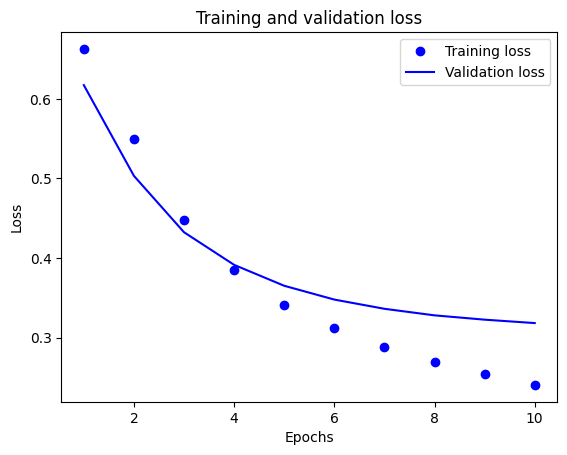

In [68]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

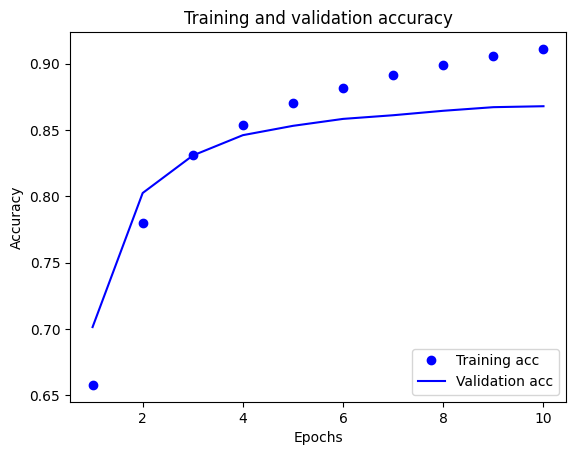

In [69]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
# tf.keras.callbacks.EarlyStopping

## Export model

In [74]:
# Including TextVectorizer layer inside the trained model to simplify model deployment
export_model = tf.keras.Sequential(
    [
        vectorize_layer,
        model,
        layers.Activation("sigmoid"),
        layers.Softmax() # Arbitrarily add softmax
    ]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)

In [75]:
# test exported model with "raw_test_dataset"
metrics = export_model.evaluate(raw_test_dataset, return_dict=True)
print(metrics)

c:\Users\HP\Desktop\ken\Project\Project ML\pyenv\lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5033 - loss: 0.7040
{'accuracy': 0.5, 'loss': 0.7057347893714905}


## Inferencing on new data

In [78]:
examples = tf.constant(
    [
        "The movie was great!",
        "The movie was okay.",
        "The movie was terrible. . .",
        "The movie was great, but not watching it maybe better"
    ]
)

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [79]:
print(f"Label 0: {raw_train_dataset.class_names[0]} review")
print(f"Label 1: {raw_train_dataset.class_names[1]} review")

Label 0: neg review
Label 1: pos review


---